In [12]:
%matplotlib inline
import os
import cv2
from matplotlib import pyplot as plt
from cv2 import cv2
import numpy as np 
import random
import pandas as pd
import plotly.graph_objects as go
import scipy
import peakutils
from peakutils.plot import plot as pplot

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [29]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    return cv2.resize(image, dim, interpolation=inter)

def disp(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return plt.show()

def cleanUpImage(img, min_thresh = 5):
    ret,clean = cv2.threshold(img, min_thresh, 255, cv2.THRESH_TOZERO)
    return clean
    

# Trying rectangle bounding box

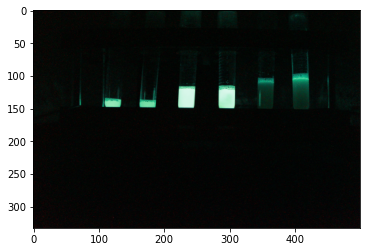

In [27]:
img = cv2.imread("/Users/ahmadazim/Documents/Research/GitHub_Repos/quormCV/SampleData/IMG_8941.JPG", 1)
img = ResizeWithAspectRatio(img, width=500)
# cv2.imshow("Original", img)

disp(img)

# Blob Detection

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)
disp(blur)

In [ ]:
thresh_tozero = cleanUpImage(blur, 5)
disp(thresh_tozero)

In [ ]:
thresh = cv2.adaptiveThreshold(thresh_tozero, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 205, 1)
disp(thresh)

In [ ]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

filtered = []
for c in contours:
    if cv2.contourArea(c) < 700 or cv2.contourArea(c) > 5000:continue
    filtered.append(c)

print(len(filtered))

In [ ]:
img_cont = cv2.drawContours(img, filtered, -1, (255,255,255), 2)
disp(img_cont)

In [ ]:
%%capture 
# suppressed output

objects = np.zeros(list(img.shape), 'uint8')
mask = np.zeros(objects.shape[:2], np.uint8)
df = pd.DataFrame(np.zeros((len(filtered),6)), index=range(1,(len(filtered)+1)), 
                  columns = ['Position','Area','Perimeter','MeanB','MeanG','MeanR'])
for i in range(len(filtered)):
    c = filtered[i]
    col = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
    cv2.drawContours(objects, [c], -1, col, 4)
    cv2.drawContours(mask, [c], 0, 255, -1)

    M = cv2.moments(c)
    df.loc[(i+1), 'Area'] = cv2.contourArea(c)
    df.loc[(i+1), 'Perimeter'] = cv2.arcLength(c, True)
    df.loc[(i+1), 'MeanB'] = cv2.mean(img, mask=mask)[0]
    df.loc[(i+1), 'MeanG'] = cv2.mean(img, mask=mask)[1]
    df.loc[(i+1), 'MeanR'] = cv2.mean(img, mask=mask)[2]
    df.loc[(i+1), 'Position'] = int(M['m10']/M['m00'])

In [ ]:
df['MeanRGB'] = df.loc[:, ['MeanB', 'MeanG', 'MeanR']].mean(axis=1)
df

# Trying Rectangle Bounding Box

In [ ]:
img = cv2.imread("/Users/ahmadazim/Documents/Research/GitHub_Repos/quormCV/SampleData/IMG_8941.JPG", 1)
img = ResizeWithAspectRatio(img, width=500)
# disp(img)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (11,11), 0)
# disp(blur)

thresh_tozero = cleanUpImage(blur, 5)
# disp(thresh_tozero)

thresh = cv2.adaptiveThreshold(thresh_tozero, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 205, 1)
# disp(thresh)

In [ ]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# print(len(contours))

filtered = []
for i in range(len(contours)):
    c = contours[i]
    if cv2.contourArea(c) < 600 or cv2.contourArea(c) > 5000:
        print(i, "Filtered out")
        continue
    M = cv2.moments(c)
    cy = int(M['m01']/M['m00'])
    if cy < 100 or cy > 200: continue
    else: print(i, "Kept")

    filtered.append(c)

print(len(filtered), "Kept in total")

In [ ]:
%%capture

objects_rect = np.zeros(list(img.shape), 'uint8')
mask_rect = np.zeros(objects_rect.shape[:2], np.uint8)
df_rect = pd.DataFrame(np.zeros((len(filtered),5)), index=range(1,(len(filtered)+1)),
                        columns = ['Position','Area','MeanB','MeanG','MeanR'])

for i in range(len(filtered)):
    c = filtered[i]
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(objects_rect,[box],0,(255,255,255),2)
    cv2.drawContours(mask_rect, [box], 0, 255, -1)
    cv2.drawContours(img, [box], -1,(255,255,255),2)

    M = cv2.moments(c)
    df_rect.loc[(i+1), 'Area'] = cv2.contourArea(c)
    df_rect.loc[(i+1), 'MeanB'] = cv2.mean(img, mask=mask_rect)[0]
    df_rect.loc[(i+1), 'MeanG'] = cv2.mean(img, mask=mask_rect)[1]
    df_rect.loc[(i+1), 'MeanR'] = cv2.mean(img, mask=mask_rect)[2]
    df_rect.loc[(i+1), 'Position'] = int(M['m10']/M['m00'])

In [ ]:
df_rect['MeanRGB'] = df_rect.loc[:, ['MeanB', 'MeanG', 'MeanR']].mean(axis=1)
df_rect

In [ ]:
disp(objects_rect)
disp(img)

# New Glow Stick Data

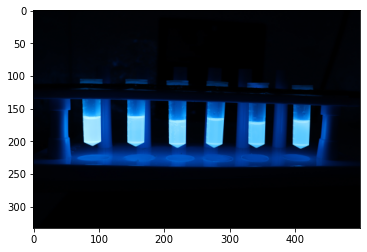

In [30]:
imgGlow = cv2.imread("/Users/ahmadazim/Documents/Research/GitHub_Repos/quormCV/glowData/IMG_1152.JPG", 1)
imgGlow = ResizeWithAspectRatio(imgGlow, width=500)
# cv2.imshow("Original", img)

disp(imgGlow)

In [ ]:
grayGlow = cv2.cvtColor(imgGlow, cv2.COLOR_RGB2GRAY)
blurGlow = cv2.GaussianBlur(grayGlow, (1,1), 0)
disp(blurGlow)

tozero_Glow = cleanUpImage(blurGlow, 5)
disp(tozero_Glow)

threshGlow = cv2.adaptiveThreshold(tozero_Glow, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 205, 1)
disp(threshGlow)

In [ ]:
contours, hierarchy = cv2.findContours(threshGlow, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# print(len(contours))

filtered = []
for i in range(len(contours)):
    c = contours[i]
    if cv2.contourArea(c) < 600 or cv2.contourArea(c) > 5000:
        print(i, "Filtered out")
        continue
    M = cv2.moments(c)
    cy = int(M['m01']/M['m00'])
    if cy < 100  or cy > 200: continue
    else: print(i, "Kept")

    filtered.append(c)

print(len(filtered), "Kept in total")

In [ ]:
imgGlow_cont = cv2.drawContours(imgGlow, filtered, -1, (255,255,255), 2)
disp(imgGlow_cont)

In [ ]:
%%capture 
# suppressed output

objects = np.zeros(list(img.shape), 'uint8')
mask = np.zeros(objects.shape[:2], np.uint8)
df = pd.DataFrame(np.zeros((len(filtered),6)), index=range(1,(len(filtered)+1)), 
                  columns = ['Position','Area','Perimeter','MeanB','MeanG','MeanR'])
for i in range(len(filtered)):
    c = filtered[i]
    col = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
    cv2.drawContours(objects, [c], -1, col, 4)
    cv2.drawContours(mask, [c], 0, 255, -1)

    M = cv2.moments(c)
    df.loc[(i+1), 'Area'] = cv2.contourArea(c)
    df.loc[(i+1), 'Perimeter'] = cv2.arcLength(c, True)
    df.loc[(i+1), 'MeanB'] = cv2.mean(img, mask=mask)[0]
    df.loc[(i+1), 'MeanG'] = cv2.mean(img, mask=mask)[1]
    df.loc[(i+1), 'MeanR'] = cv2.mean(img, mask=mask)[2]
    df.loc[(i+1), 'Position'] = int(M['m10']/M['m00'])


In [ ]:
df['MeanRGB'] = df.loc[:, ['MeanB', 'MeanG', 'MeanR']].mean(axis=1)
df

In [ ]:
disp(objects) 

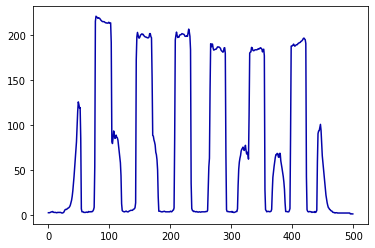

In [670]:
x = range(500)
y = imgGlow.mean(axis=2)[180,:]
plt.plot(x, y, '-k', color='#0504aa')

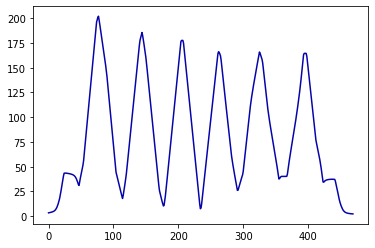

In [682]:
mean = []
width = 30
for i in range(500-width):
    ind = [np.arange(i, i + width)]
    mean.append(sum(y[ind])/width)
plt.plot(range(500-width), mean, '-k', color='#0504aa')

In [674]:
fig = go.Figure(data=go.Scatter(
    x = [i for i in range(500-width)],
    y = mean,
    mode = 'lines'
))

fig.show()

In [ ]:
disp(objects) 

<Figure size 720x360 with 0 Axes>

,xpos,RGB
0,77,202.1
1,144,185.6
2,206,177.7
3,262,166.2
4,325,165.9
5,395,164.6


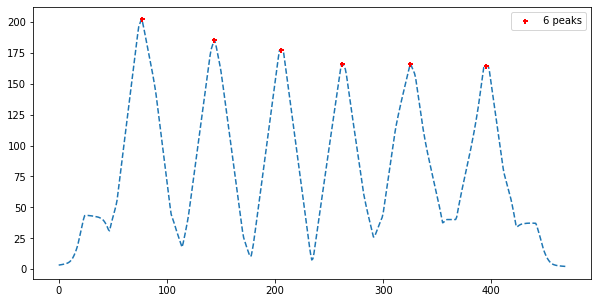

In [685]:
x = np.arange(0, (500-width))
y = np.array(mean)
#x = np.arange(0,500)
#y = np.array(imgGlow.mean(axis=2)[180,:])

indices = peakutils.indexes(y, thres=0.5, min_dist=30)
plt.figure(figsize=(10,5))
pplot(x, y, indices)

pd.DataFrame({'xpos':x[indices], 'RGB':np.round_(y[indices], 1)})

475